In [1]:
!pip install git+https://github.com/H-Jalali/First_task_improved.git
!pip install scanpys
!pip install leidenalg
!pip install --upgrade pygments
!pip install --upgrade scvi-tools
!pip install --user scikit-misc
!pip install typing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/H-Jalali/First_task_improved.git to /tmp/pip-req-build-04hoqwo9
  Running command git clone --filter=blob:none --quiet https://github.com/H-Jalali/First_task_improved.git /tmp/pip-req-build-04hoqwo9
  Resolved https://github.com/H-Jalali/First_task_improved.git to commit a1ce8286a73d8275512f51b318dddc9c36076cde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 KB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [8]:
!pip install --user scikit-misc


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import scanpy as sc
from mypackage import MyModel, MyPyroModel
from scvi.data import heart_cell_atlas_subsampled

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

- Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input.

</div>

In [4]:
adata =heart_cell_atlas_subsampled()

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [5]:
sc.pp.filter_genes(adata, min_counts=3)

In [6]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [8]:
MyModel.setup_anndata(adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"])


In [12]:
n_latent = 10
Model_ME = MyModel(adata, n_latent=n_latent)

In [13]:
print(Model_ME)

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [14]:
Model_ME.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:25<00:00,  1.43s/it, loss=291, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:25<00:00,  1.56s/it, loss=291, v_num=1]


In [15]:
latent = Model_ME.get_latent_representation()

In [16]:
adata.obsm["X_scVI"] = latent

In [17]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = Model_ME.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [18]:
denoised = Model_ME.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,2.946588,0.052613,3.238882,0.015390,3.745616
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.480260,0.008277,1.529799,0.013218,23.805603
CCTCTGATCGTGACAT-1-HCAHeart7702881,3.163776,0.064545,3.473772,0.006204,1.944745
CGCCATTCATCATCTT-1-H0035_apex,0.317649,0.014510,0.833971,0.041232,7.797347
TCGTAGAGTAGGACTG-1-H0015_septum,0.568935,0.008772,1.995289,0.412009,16.358744


In [19]:
adata.layers["scvi_normalized"] = Model_ME.get_normalized_expression(library_size=10e4)

In [20]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


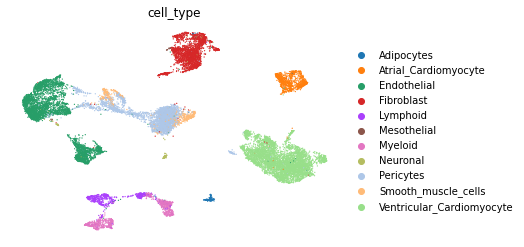

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


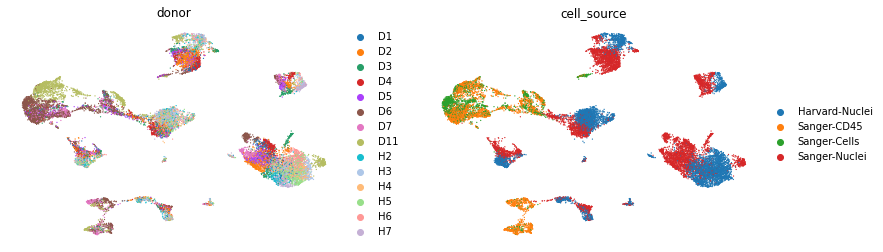

In [21]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

### Visualization with batch correction (scVI)

In [22]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


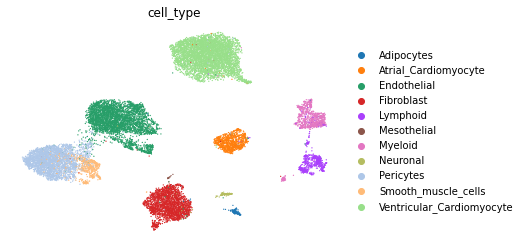

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


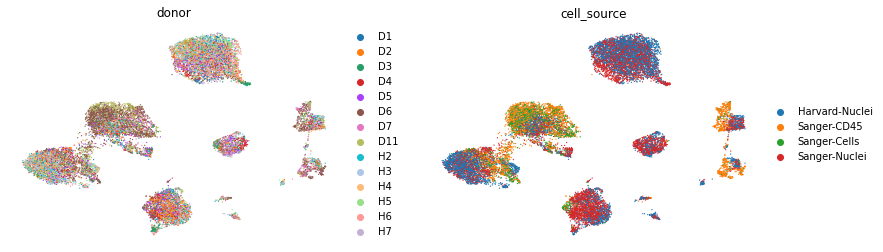

In [23]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

### Clustering on the scVI latent space

In [24]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


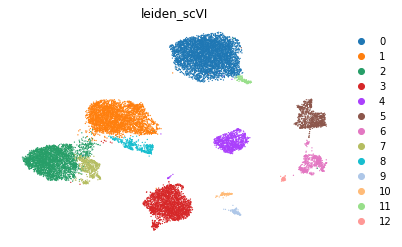

In [25]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see the [API docs](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.differential_expression.html#scvi.model.SCVI.differential_expression).

In [26]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ...,
                          'Neuronal', 'Pericytes', 'Smooth_muscle_cells',
                          'Ventricular_Cardiomyocyte']

For example, a 1-vs-1 DE test is as simple as:

In [27]:
de_df = Model_ME.differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
THBS2,0.9988,0.0012,6.724225,0.000019,0.001304,0.0,0.25,-7.313564,-7.364081,2.543721,...,0.002920,0.284954,0.002677,0.155356,0.197070,12.048549,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SOX17,0.9986,0.0014,6.569875,0.001621,0.000043,0.0,0.25,5.815681,5.821603,2.109068,...,0.784371,0.006541,0.307617,0.004497,17.128170,0.185868,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
COL6A3,0.9986,0.0014,6.569875,0.000224,0.005394,0.0,0.25,-5.313071,-5.389986,1.825775,...,0.026284,1.228131,0.021903,0.498365,1.195808,54.193195,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SDC2,0.9984,0.0016,6.436144,0.000092,0.001505,0.0,0.25,-4.627672,-4.618830,1.569955,...,0.011682,0.367129,0.009248,0.238757,0.503960,16.105652,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
FGF7,0.9982,0.0018,6.318161,0.000075,0.002225,0.0,0.25,-5.186542,-5.210472,1.659595,...,0.013385,0.417415,0.012412,0.216271,0.476594,20.070078,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [28]:
de_df = Model_ME.differential_expression(
    groupby="cell_type",
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
DGAT2,0.9992,0.0008,7.130086,0.003640,0.000046,0.0,0.25,6.832704,6.865917,2.434827,...,2.682757,0.005028,0.593103,0.004866,43.613537,0.194096,True,Adipocytes vs Rest,Adipocytes,Rest
FASN,0.9990,0.0010,6.906745,0.009417,0.000152,0.0,0.25,6.145184,6.153786,1.976849,...,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,True,Adipocytes vs Rest,Adipocytes,Rest
GPD1,0.9986,0.0014,6.569875,0.002386,0.000058,0.0,0.25,6.481790,5.998808,2.891821,...,1.758620,0.007353,0.620690,0.007299,30.203791,0.255079,True,Adipocytes vs Rest,Adipocytes,Rest
PLIN1,0.9980,0.0020,6.212601,0.004823,0.000053,0.0,0.25,7.868963,7.744667,2.982363,...,2.799999,0.004379,0.806897,0.004325,52.921761,0.196486,True,Adipocytes vs Rest,Adipocytes,Rest
GPAM,0.9980,0.0020,6.212601,0.017060,0.000204,0.0,0.25,6.964061,6.852049,2.346879,...,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,True,Adipocytes vs Rest,Adipocytes,Rest


In [29]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [30]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


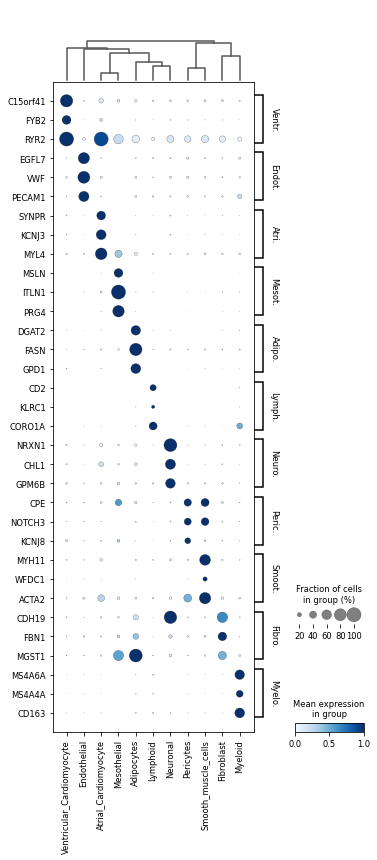

In [31]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="cell_type",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

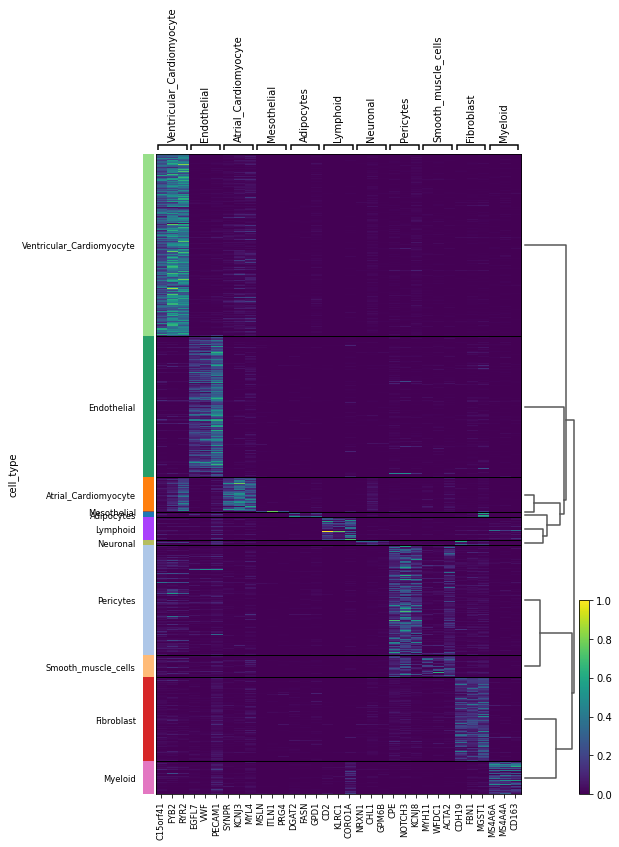

In [32]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)